In [33]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import copy
import logging
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import seaborn as sns
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from collab.foraging import central_park_birds as cpb
from collab.foraging.central_park_birds.central_park import (
    cp_add_how_far_squared_scaled,
    cp_generate_proximity_score,
)
from collab.utils import find_repo_root

root = find_repo_root()
from collab.foraging import toolkit as ft

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

import matplotlib.pyplot as plt

notebook_starts = time.time()

Some issues to fix:
- frames input in ft.utils.object_from_data doesn't actually change anything. Either remove input, or make it actually change the frame range.
- ft.animate_foragers plot overflows, check if it returns figure, and if fig can be resized
- ft.animate_foragers assumes no timebins are skipped
- sometimes get comfusing bugs when running on too little data (e.g. just 100 frames)

In [34]:
# load the data
path = os.path.join(
    root,
    "data/foraging/gerbils/2020_08_01_18_10_16_589437_compressed_Day_spine (1).npy",
    # "data/foraging/gerbils/2020_07_23_18_29_24_027132_compressed_Day_spine.npy",
)
data = np.load(path)

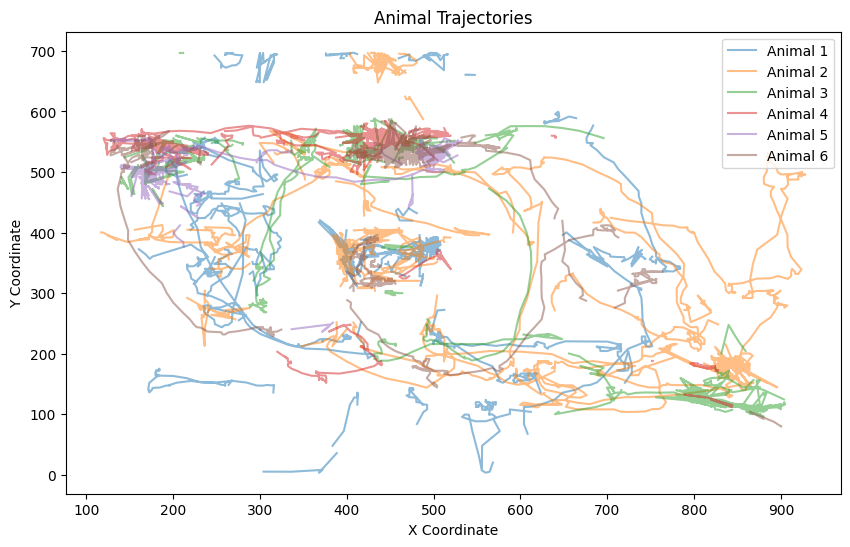

In [35]:
# plot the data
# the dimensions of the data are (time, animal_num, XY)

#  data shape is (time, animal_num, XY)

time_steps, animal_num, _ = data.shape

# Create a plot for each animal's trajectory
plt.figure(figsize=(10, 6))

tmin = 500
tmax = 5000

for i in range(animal_num):
    # Extract the X and Y coordinates for the current animal
    x_coords = data[tmin:tmax, i, 0]
    y_coords = data[tmin:tmax, i, 1]

    # Plot the trajectory
    plt.plot(x_coords, y_coords, label=f"Animal {i+1}", alpha=0.5)

# Add labels and a legend
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Animal Trajectories")
plt.legend()

# Show the plot
plt.show()

In [36]:
# Format the data in dataframes as expected for further analysis

# make a dataframe with columns for x, y, time, forager (animal_num), and type (always gerbil)
# Initialize lists to hold the data for the dataframe
time_list = []
forager_list = []
x_list = []
y_list = []
type_list = []

# Populate the lists with the data
for timei in range(time_steps):
    for forager in range(animal_num):
        x_list.append(data[timei, forager, 0])
        y_list.append(data[timei, forager, 1])
        time_list.append(timei)
        forager_list.append(forager)
        type_list.append("gerbil")

# Create the dataframe
gerbil_df = pd.DataFrame(
    {
        "time": time_list,
        "forager": forager_list,
        "x": x_list,
        "y": y_list,
        "type": type_list,
    }
)


# Define the range and location for rewards
x_range = range(250, 651)  # x locations from 250 to 650
y_location = 700  # y location fixed at 700

# Use numpy to efficiently create arrays for the rewards DataFrame
x_array = np.tile(np.arange(250, 651), time_steps)
y_array = np.full(x_array.shape, y_location)
time_array = np.repeat(np.arange(time_steps), len(x_range))

# Create the rewards DataFrame
rewardsDF = pd.DataFrame({"x": x_array, "y": y_array, "time": time_array})

# Remove times where any value in gerbil_df is NaN
nan_times = gerbil_df[gerbil_df.isna().any(axis=1)]["time"]

# Filter gerbil_df to exclude rows with these times
gerbil_df_clean = gerbil_df[~gerbil_df["time"].isin(nan_times)]

# Filter rewardsDF to exclude rows with these times
rewardsDF_clean = rewardsDF[~rewardsDF["time"].isin(nan_times)]

# Display the cleaned DataFrames
print(gerbil_df_clean.head())
print(gerbil_df_clean["time"].unique().shape)
print(rewardsDF_clean.head())

# restrict to time range
gerbil_df_clean = gerbil_df_clean[
    (gerbil_df_clean["time"] >= tmin) & (gerbil_df_clean["time"] <= tmax)
]
rewardsDF_clean = rewardsDF_clean[
    (rewardsDF_clean["time"] >= tmin) & (rewardsDF_clean["time"] <= tmax)
]

forager_object = ft.utils.object_from_data(
    gerbil_df_clean,
    grid_size=1000,
    rewardsDF=rewardsDF_clean,
    frames=None,
    calculate_step_size_max=True,
)

      time  forager           x           y    type
2922   487        0  788.811279  583.877930  gerbil
2923   487        1  395.837769  379.639740  gerbil
2924   487        2  199.334747  504.811859  gerbil
2925   487        3  388.397308  243.945663  gerbil
2926   487        4  180.298141  495.453278  gerbil
(7946,)
          x    y  time
195287  250  700   487
195288  251  700   487
195289  252  700   487
195290  253  700   487
195291  254  700   487


In [37]:
# ft.animate_foragers(
#     forager_object, plot_rewards=True, width=1000, height=710, point_size=6
# )

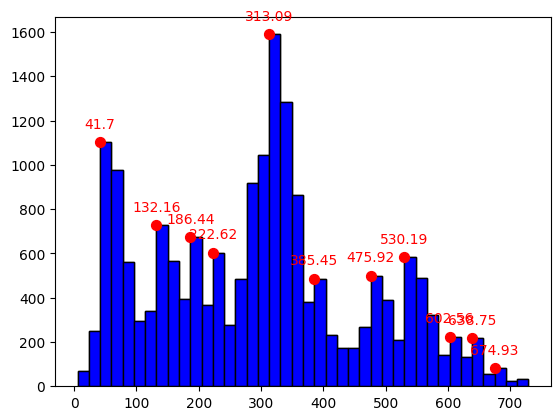

In [38]:
forager_distances = ft.foragers_to_forager_distances(forager_object)
ft.distances_and_peaks(forager_distances)

# this seems multimodal, let's generate different proximity predictors centered approximately around the peaks
# 40, 150, 180, 280, 330

In [39]:
forager_vis = cpb.cp_generate_visibility(
    forager_object.foragers,
    grid_size=forager_object.grid_size,
    visibility_range=300,
    sampling_rate=0.001,
)
forager_object.visibility = forager_vis["visibility"]
forager_object.visibilityDF = forager_vis["visibilityDF"]
display(forager_object.visibilityDF.head())
display(forager_object.visibilityDF.shape)

,x,y,distance,distance_x,distance_y,visibility,forager,time
987231,988,232,15.055602,576.073303,462.737732,0.996894,1,785
500891,501,892,23.930548,89.073303,197.262268,0.992160,1,785
733378,734,379,3.559655,322.073303,315.737732,0.999826,1,785
731479,732,480,14.514515,320.073303,214.737732,0.997114,1,785
399758,400,759,10.230892,11.926697,64.262268,0.998566,1,785


(2183767, 8)

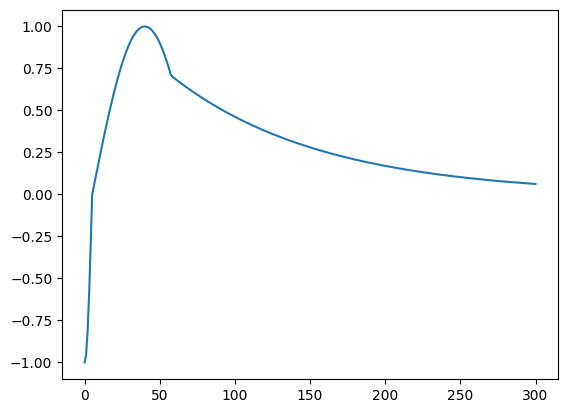

In [40]:
# plot proximity score as a function of distance between foragers
distances = np.linspace(0, 300, 300)
scores = []
for distance in distances:
    scores.append(ft.proximity.proximity_score(distance, getting_worse=40/8, optimal=40, proximity_decay=.01))
plt.plot(distances, scores)

In [41]:
optimal_candidates = [40, 300]
proximity_dict = {}
for candidate in optimal_candidates:
    proximity_dict[str(candidate)] = cp_generate_proximity_score(
        forager_object,
        visibility_range=300,
        getting_worse= candidate/8,
        optimal=candidate,
        proximity_decay=.02,
        forager_distances=forager_distances,
    )

# just to be used by how far, doesnt matter which one we grab here
forager_object.proximity = proximity_dict["40"]["proximity"]
forager_object.proximityDF = proximity_dict["40"]["proximityDF"]

/Users/emily/code/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/emily/code/collaborative-intelligence/collab/foraging/central_park_birds/central_park.py:140: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [42]:
optimal_candidates = ["40", "300"]

proximity_frames = []

for candidate in optimal_candidates:

    proximity_dict[candidate]["proximityDF"].rename(
        columns={
            "proximity": f"proximity_{candidate}",
            "proximity_standardized": f"proximity_standardized_{candidate}",
        },
        inplace=True,
    )

    display(proximity_dict[candidate]["proximityDF"].head())
    proximity_frames.append(proximity_dict[candidate]["proximityDF"])

result_df = proximity_frames[0]

for i in range(1, len(proximity_frames)):
    proximity_predictors = proximity_frames[i].iloc[:, -2:]
    result_df = pd.concat([result_df, proximity_predictors], axis=1)

display(result_df.head())

,x,y,distance,distance_x,distance_y,visibility,forager,time,proximity_40,proximity_standardized_40
987231,988,232,15.055602,576.073303,462.737732,0.996894,1,785,4.392492e-08,-0.337923
500891,501,892,23.930548,89.073303,197.262268,0.992160,1,785,1.466141e-04,-0.196389
733378,734,379,3.559655,322.073303,315.737732,0.999826,1,785,1.398472e-05,-0.324461
731479,732,480,14.514515,320.073303,214.737732,0.997114,1,785,2.212623e-05,-0.316599
399758,400,759,10.230892,11.926697,64.262268,0.998566,1,785,3.946672e-03,3.473097


,x,y,distance,distance_x,distance_y,visibility,forager,time,proximity_300,proximity_standardized_300
987231,988,232,15.055602,576.073303,462.737732,0.996894,1,785,0.000077,-0.599182
500891,501,892,23.930548,89.073303,197.262268,0.992160,1,785,0.258540,0.195906
733378,734,379,3.559655,322.073303,315.737732,0.999826,1,785,0.024661,-0.523559
731479,732,480,14.514515,320.073303,214.737732,0.997114,1,785,0.039017,-0.479394
399758,400,759,10.230892,11.926697,64.262268,0.998566,1,785,0.994881,2.461059


,x,y,distance,distance_x,distance_y,visibility,forager,time,proximity_40,proximity_standardized_40,proximity_300,proximity_standardized_300
987231,988,232,15.055602,576.073303,462.737732,0.996894,1,785,4.392492e-08,-0.337923,0.000077,-0.599182
500891,501,892,23.930548,89.073303,197.262268,0.992160,1,785,1.466141e-04,-0.196389,0.258540,0.195906
733378,734,379,3.559655,322.073303,315.737732,0.999826,1,785,1.398472e-05,-0.324461,0.024661,-0.523559
731479,732,480,14.514515,320.073303,214.737732,0.997114,1,785,2.212623e-05,-0.316599,0.039017,-0.479394
399758,400,759,10.230892,11.926697,64.262268,0.998566,1,785,3.946672e-03,3.473097,0.994881,2.461059


In [43]:
if "distance_x" in result_df.columns and "distance_y" in result_df.columns:
    result_df.drop(columns=["distance_x", "distance_y"], inplace=True)

In [44]:
cp_add_how_far_squared_scaled(forager_object)

forager_object.how_farDF.head()

result_df = pd.concat([result_df, forager_object.how_farDF.iloc[:, -3:]], axis=1)
display(result_df.head())

,x,y,distance,visibility,forager,time,proximity_40,proximity_standardized_40,proximity_300,proximity_standardized_300,how_far_squared,how_far,how_far_squared_scaled
987231,988,232,15.055602,0.996894,1,785,4.392492e-08,-0.337923,0.000077,-0.599182,552857.0,743.543543,0.104394
500891,501,892,23.930548,0.992160,1,785,1.466141e-04,-0.196389,0.258540,0.195906,47252.0,217.375252,0.923454
733378,734,379,3.559655,0.999826,1,785,1.398472e-05,-0.324461,0.024661,-0.523559,207418.0,455.431663,0.663991
731479,732,480,14.514515,0.997114,1,785,2.212623e-05,-0.316599,0.039017,-0.479394,152281.0,390.231982,0.753311
399758,400,759,10.230892,0.998566,1,785,3.946672e-03,3.473097,0.994881,2.461059,4018.0,63.387696,0.993491


In [45]:
if "forager" in result_df.columns:
    result_df["forager_id"] = pd.factorize(result_df["forager"])[0]
    result_df.drop(columns=["forager"], inplace=True)

if "time" in result_df.columns:
    result_df["time_id"] = pd.factorize(result_df["time"])[0]
    result_df.drop(columns=["time"], inplace=True)


display(result_df.head())

# see if any nans
display(result_df.isna().sum() / len(result_df))

result_df = result_df.dropna()

display(result_df.isna().sum() / len(result_df))

,x,y,distance,visibility,proximity_40,proximity_standardized_40,proximity_300,proximity_standardized_300,how_far_squared,how_far,how_far_squared_scaled,forager_id,time_id
987231,988,232,15.055602,0.996894,4.392492e-08,-0.337923,0.000077,-0.599182,552857.0,743.543543,0.104394,0,0
500891,501,892,23.930548,0.992160,1.466141e-04,-0.196389,0.258540,0.195906,47252.0,217.375252,0.923454,0,0
733378,734,379,3.559655,0.999826,1.398472e-05,-0.324461,0.024661,-0.523559,207418.0,455.431663,0.663991,0,0
731479,732,480,14.514515,0.997114,2.212623e-05,-0.316599,0.039017,-0.479394,152281.0,390.231982,0.753311,0,0
399758,400,759,10.230892,0.998566,3.946672e-03,3.473097,0.994881,2.461059,4018.0,63.387696,0.993491,0,0


x                             0.000000
y                             0.000000
distance                      0.000000
visibility                    0.000000
proximity_40                  0.000000
proximity_standardized_40     0.000000
proximity_300                 0.000000
proximity_standardized_300    0.000000
how_far_squared               0.001509
how_far                       0.001509
how_far_squared_scaled        0.001509
forager_id                    0.000000
time_id                       0.000000
dtype: float64

x                             0.0
y                             0.0
distance                      0.0
visibility                    0.0
proximity_40                  0.0
proximity_standardized_40     0.0
proximity_300                 0.0
proximity_standardized_300    0.0
how_far_squared               0.0
how_far                       0.0
how_far_squared_scaled        0.0
forager_id                    0.0
time_id                       0.0
dtype: float64

<Axes: >

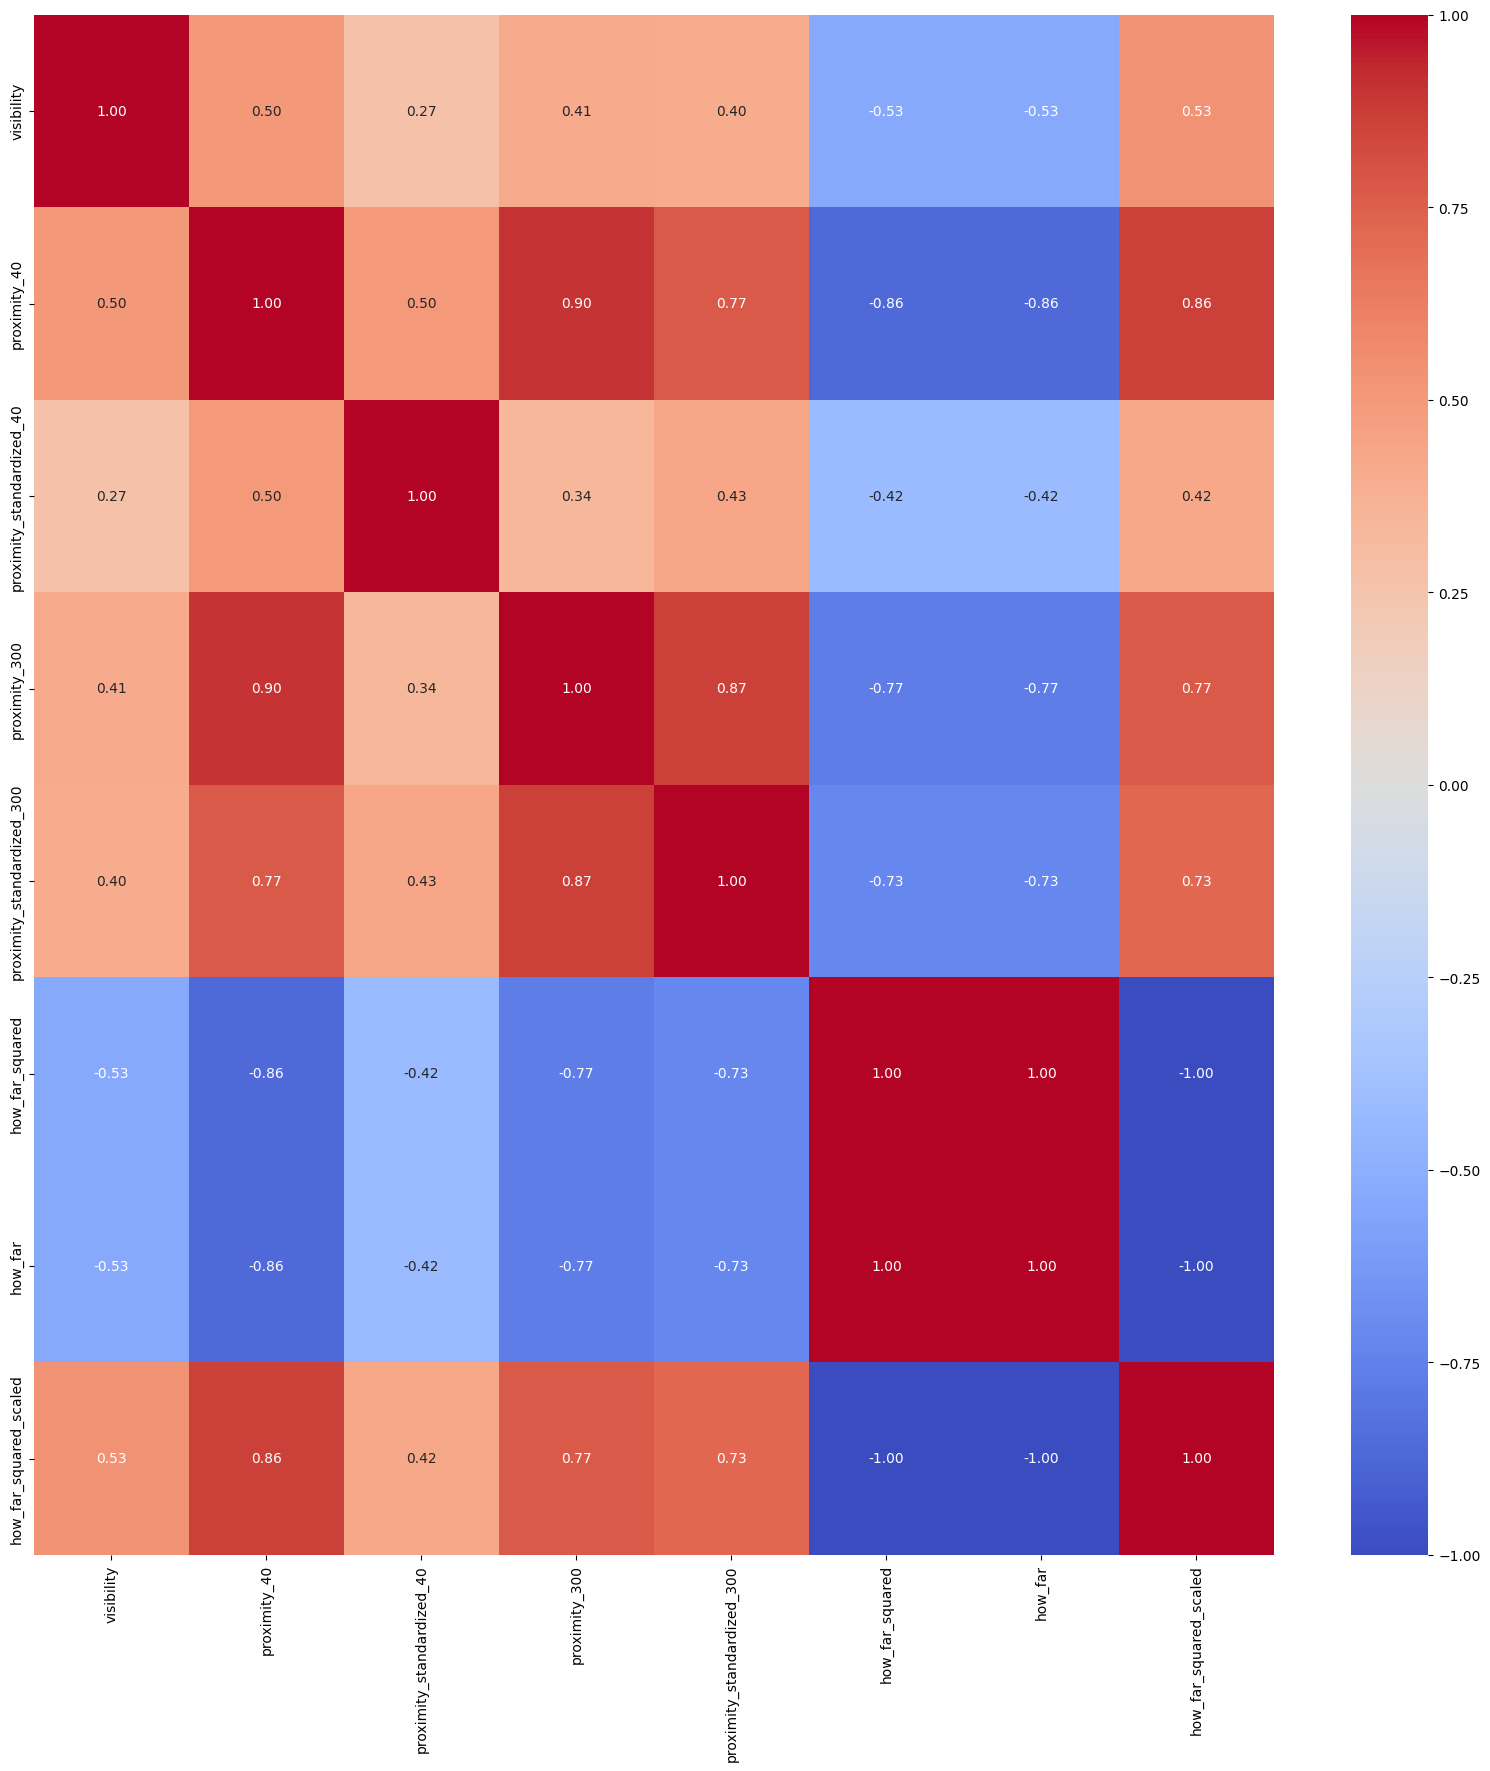

In [46]:
# inspect spearman correlation between different predictor scores in result_df
corr = result_df.iloc[:, 3:-2].corr(method="spearman")
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

# note strong correlations between proximity predictors

In [47]:
inference_data_sampling_rate = 0.05
inference_data = result_df.sample(frac=inference_data_sampling_rate)
print(f"Using {len(inference_data)} samples out of {len(result_df)} for inference")
predictors = {
    key: torch.tensor(inference_data[key].values) for key in inference_data.columns
}

Using 109024 samples out of 2180472 for inference


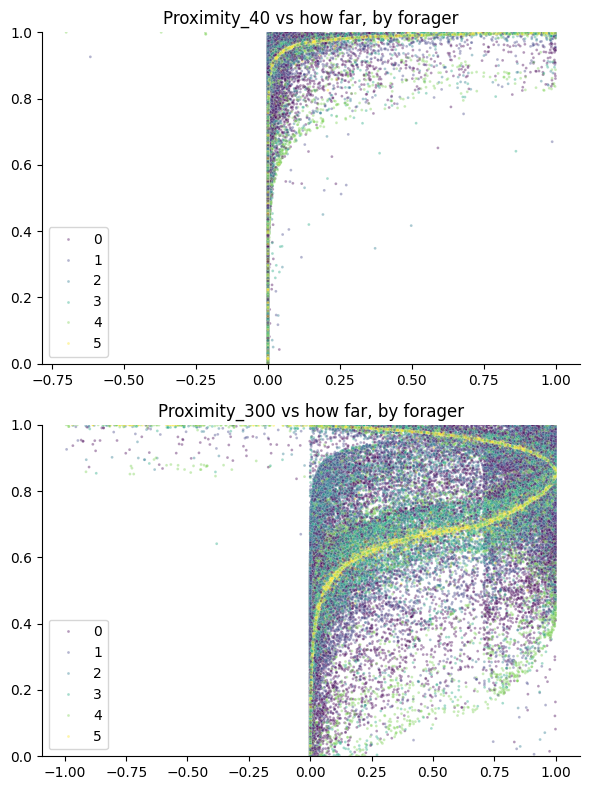

In [48]:
# further subsample for plotting and plot
sampling_rate = 1

fig, axes = plt.subplots(
    len(optimal_candidates), 1, figsize=(6, len(optimal_candidates) * 4)
)

if len(optimal_candidates) == 1:
    axes = [axes]

for i, (proximity, ax) in enumerate(zip(optimal_candidates, axes)):

    total_samples = predictors[f"proximity_{proximity}"].size(0)
    sample_indices = torch.randperm(total_samples)[: int(sampling_rate * total_samples)]

    x_data = predictors[f"proximity_{proximity}"][sample_indices].cpu().numpy()
    y_data = predictors["how_far_squared_scaled"][sample_indices].cpu().numpy()
    hue_data = predictors["forager_id"][sample_indices].cpu().numpy()

    sns.scatterplot(
        x=x_data, y=y_data, hue=hue_data, palette="viridis", s=4, alpha=0.4, ax=ax
    )

    ax.set_ylim(0, 1)
    ax.set_title(f"Proximity_{proximity} vs how far, by forager")
    sns.despine()
    plt.tight_layout()
    ax

In [49]:
predictors.keys()

dict_keys(['x', 'y', 'distance', 'visibility', 'proximity_40', 'proximity_standardized_40', 'proximity_300', 'proximity_standardized_300', 'how_far_squared', 'how_far', 'how_far_squared_scaled', 'forager_id', 'time_id'])

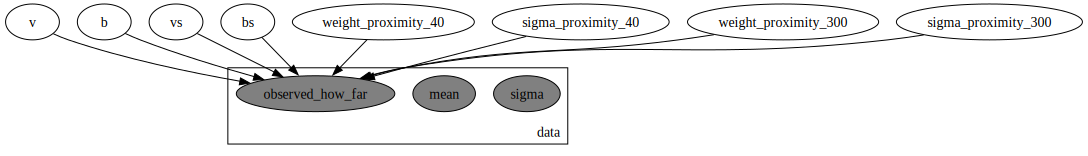

In [50]:
class GerbilModel(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.4,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=predictors,
        proximities=[40, 300],
        leeway=0.4,
    ):
        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]

        proximity_names = [f"proximity_{proximity}" for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}

        v = pyro.sample("v", dist.Normal(0.0, leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))

        vs = pyro.sample("vs", dist.Exponential(10.0))
        bs = pyro.sample("bs", dist.Exponential(10.0))

        weights = {}
        sigmas = {}
        for key in proximity_tensors:
            weights[key] = pyro.sample(f"weight_{key}", dist.Normal(0.0, leeway))

            sigmas[key] = pyro.sample(f"sigma_{key}", dist.Exponential(9.0))

        with pyro.plate("data", self.n):
            sigma = pyro.deterministic(
                "sigma",
                sum(
                    [
                        torch.abs(proximity_tensors[key]) * sigmas[key]
                        for key in proximity_tensors
                    ]
                )
                + vs * torch.abs(visibility)
                + bs,
            )

            assert torch.all(sigma > 0), "Sigma is not positive"

            mean = pyro.deterministic(
                "mean",
                sum(
                    [proximity_tensors[key] * weights[key] for key in proximity_tensors]
                )
                + v * visibility
                + b,
            )

            pyro.sample("observed_how_far", dist.Normal(mean, sigma), obs=how_far)


gerbil_model = GerbilModel(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model(predictors)

pyro.render_model(
    lambda: gerbil_model(predictors),
)

In [51]:
# helper function for inference


def run_svi(
    model=gerbil_model,
    data=predictors,
    proximities=[40, 300],
    num_svi_iters=num_svi_iters,
    num_samples=num_samples,
):
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model, guide, optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(data=data, proximities=proximities)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Step {}, elbo loss: {}".format(i, elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)

    if not smoke_test:
        fig = px.line(
            x=iterations, y=losses, title="ELBO loss", template="presentation"
        )
        labels = {"iterations": "iteration", "losses": "loss"}
        fig.update_xaxes(showgrid=False, title_text=labels["iterations"])
        fig.update_yaxes(showgrid=False, title_text=labels["losses"])
        fig.update_layout(width=700)
        fig.show()

    return guide

    # predictive = Predictive(
    #     model, guide=guide, num_samples=num_samples, parallel=True
    # )
    # svi_samples = predictive(proximities)


#    return {"svi_samples": svi_samples, "svi_guide": guide, "svi_predictive": predictive}

In [52]:
guide = run_svi(num_svi_iters=600)
predictive = Predictive(
    gerbil_model, guide=guide, num_samples=num_samples, parallel=True
)
samples = predictive(predictors)

2024-09-28 02:10:54,069 - Starting SVI inference with 600 iterations.
2024-09-28 02:10:54,085 - Step 0, elbo loss: 85782.43407558161
2024-09-28 02:10:55,935 - Step 200, elbo loss: 4680.257679968261
2024-09-28 02:10:57,648 - Step 400, elbo loss: 3834.650526691293
2024-09-28 02:10:59,283 - SVI inference completed in 5.21 seconds.


In [53]:
def summary(samples, vars_of_interest=None):
    if vars_of_interest is None:
        vars_of_interest = [
            "v",
            "weight_proximity_40",
            "weight_proximity_300",
        ]

    for key in vars_of_interest:
        mean = samples[key].mean(axis=0)
        std = samples[key].std(axis=0)
        print(f"{key}: {mean} +/- {std}")


summary(samples)

v: tensor([-0.0674]) +/- tensor([0.0436])
weight_proximity_40: tensor([1.0148]) +/- tensor([0.0644])
weight_proximity_300: tensor([0.5622]) +/- tensor([0.0485])


In [54]:
predictors_for_eval = copy.deepcopy(predictors)
predictors_for_eval["how_far_squared_scaled"] = None


def calculate_R_squared(model, guide, proximities=[ 40, 300]):
    predictive = pyro.infer.Predictive(
        model, guide=guide, num_samples=100, parallel=True
    )
    predictions = predictive(predictors_for_eval, proximities=proximities)

    mean_preds = predictions["observed_how_far"].mean(axis=0)

    assert not torch.equal(
        mean_preds, predictors["how_far_squared_scaled"]
    ), "Predictions should not be the same as the observed values"

    observed_mean = torch.mean(predictors["how_far_squared_scaled"])

    tss = torch.sum((predictors["how_far_squared_scaled"] - observed_mean) ** 2)
    rss = torch.sum((predictors["how_far_squared_scaled"] - mean_preds) ** 2)

    r_squared = 1 - (rss / tss)

    return r_squared.float().item()


calculate_R_squared(gerbil_model, guide)

0.49482518434524536

In [55]:
# In principle you could use single predictors, resulting in fairly reduced R^2 values for each
# example: proximity_40

guide_40 = run_svi(proximities=[40])
predictive_40 = Predictive(
    gerbil_model, guide=guide_40, num_samples=num_samples, parallel=True
)
samples_40 = predictive_40(predictors)
summary(samples_40)
calculate_R_squared(gerbil_model, guide_40, proximities=[40])

2024-09-28 02:11:01,631 - Starting SVI inference with 1000 iterations.
2024-09-28 02:11:01,642 - Step 0, elbo loss: 113545.35588925195
2024-09-28 02:11:03,038 - Step 200, elbo loss: 34519.918043679514
2024-09-28 02:11:04,439 - Step 400, elbo loss: 33708.50203675363
2024-09-28 02:11:05,853 - Step 600, elbo loss: 33533.533392091485
2024-09-28 02:11:07,282 - Step 800, elbo loss: 32894.830674699224
2024-09-28 02:11:08,706 - SVI inference completed in 7.07 seconds.


v: tensor([0.0933]) +/- tensor([0.0326])
weight_proximity_40: tensor([0.9334]) +/- tensor([0.0734])
weight_proximity_300: tensor([0.0066]) +/- tensor([0.4120])


0.05356838181614876

In [56]:
class GerbilModelNoPooling(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.4,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=None,
        proximities=[40, 300],
        leeway=0.4,
    ):
        if data is None:
            data = self.predictors

        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]
        forager_ids = data["forager_id"]
        n_foragers = len(forager_ids.unique())

        proximity_names = [f"proximity_{proximity}" for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}

        v = pyro.sample("v", dist.Normal(0.0, leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))

        vs = pyro.sample("vs", dist.Exponential(10.0))
        bs = pyro.sample("bs", dist.Exponential(10.0))

        weights = {}
        sigmas = {}
        weighted = {}
        sigmas_weighted = {}

        for key in proximity_names:
            weights[key] = pyro.sample(
                f"weight_{key}",
                dist.Normal(0.0, leeway).expand(torch.tensor([n_foragers])).to_event(1),
            )
            sigmas[key] = pyro.sample(
                f"sigma_{key}",
                dist.Exponential(9.0).expand(torch.tensor([n_foragers])).to_event(1),
            )

            weighted[key] = weights[key][..., forager_ids] * proximity_tensors[key]

            sigmas_weighted[key] = (
                torch.abs(proximity_tensors[key]) * sigmas[key][..., forager_ids]
            )

        weighted = list(weighted.values())
        sigmas_weighted = list(sigmas_weighted.values())
        for i in range(1, len(weighted)):
            weighted[i] = weighted[i].view(weighted[0].shape)
            sigmas_weighted[i] = sigmas_weighted[i].view(sigmas_weighted[0].shape)

        mean = pyro.deterministic(
            "mean", torch.stack(weighted).sum(dim=0) + b + visibility * v
        )
        sigma = pyro.deterministic(
            "sigma", torch.stack(sigmas_weighted).sum(dim=0) + bs + visibility * vs
        )

        with pyro.plate("data", self.n, dim=-1):
            pyro.sample("observed_how_far", dist.Normal(mean, sigma), obs=how_far)


gerbil_model_no_pooling = GerbilModelNoPooling(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model_no_pooling(predictors)

In [57]:
guide_no_pooling = run_svi(gerbil_model_no_pooling, num_svi_iters=600)
predictive_no_pooling = Predictive(
    gerbil_model_no_pooling, guide=guide_no_pooling, num_samples=1000
)
samples_no_pooling = predictive_no_pooling(predictors)

2024-09-28 02:11:09,922 - Starting SVI inference with 600 iterations.
2024-09-28 02:11:09,968 - Step 0, elbo loss: 67438.76212545409
2024-09-28 02:11:18,855 - Step 200, elbo loss: 16910.313997752484
2024-09-28 02:11:27,812 - Step 400, elbo loss: 1441.020506897337
2024-09-28 02:11:36,652 - SVI inference completed in 26.73 seconds.


In [58]:
# note the params differ across individuals, R is slightly improved
summary(samples_no_pooling)
calculate_R_squared(gerbil_model_no_pooling, guide_no_pooling)



v: tensor([-0.0724]) +/- tensor([0.0403])
weight_proximity_40: tensor([[1.0555, 0.9821, 0.9429, 1.0103, 0.9925, 1.1019]]) +/- tensor([[0.0686, 0.0666, 0.0712, 0.0665, 0.0668, 0.0708]])
weight_proximity_300: tensor([[0.5316, 0.5639, 0.5837, 0.5938, 0.5067, 0.5737]]) +/- tensor([[0.0429, 0.0491, 0.0466, 0.0469, 0.0458, 0.0505]])


0.49497190117836

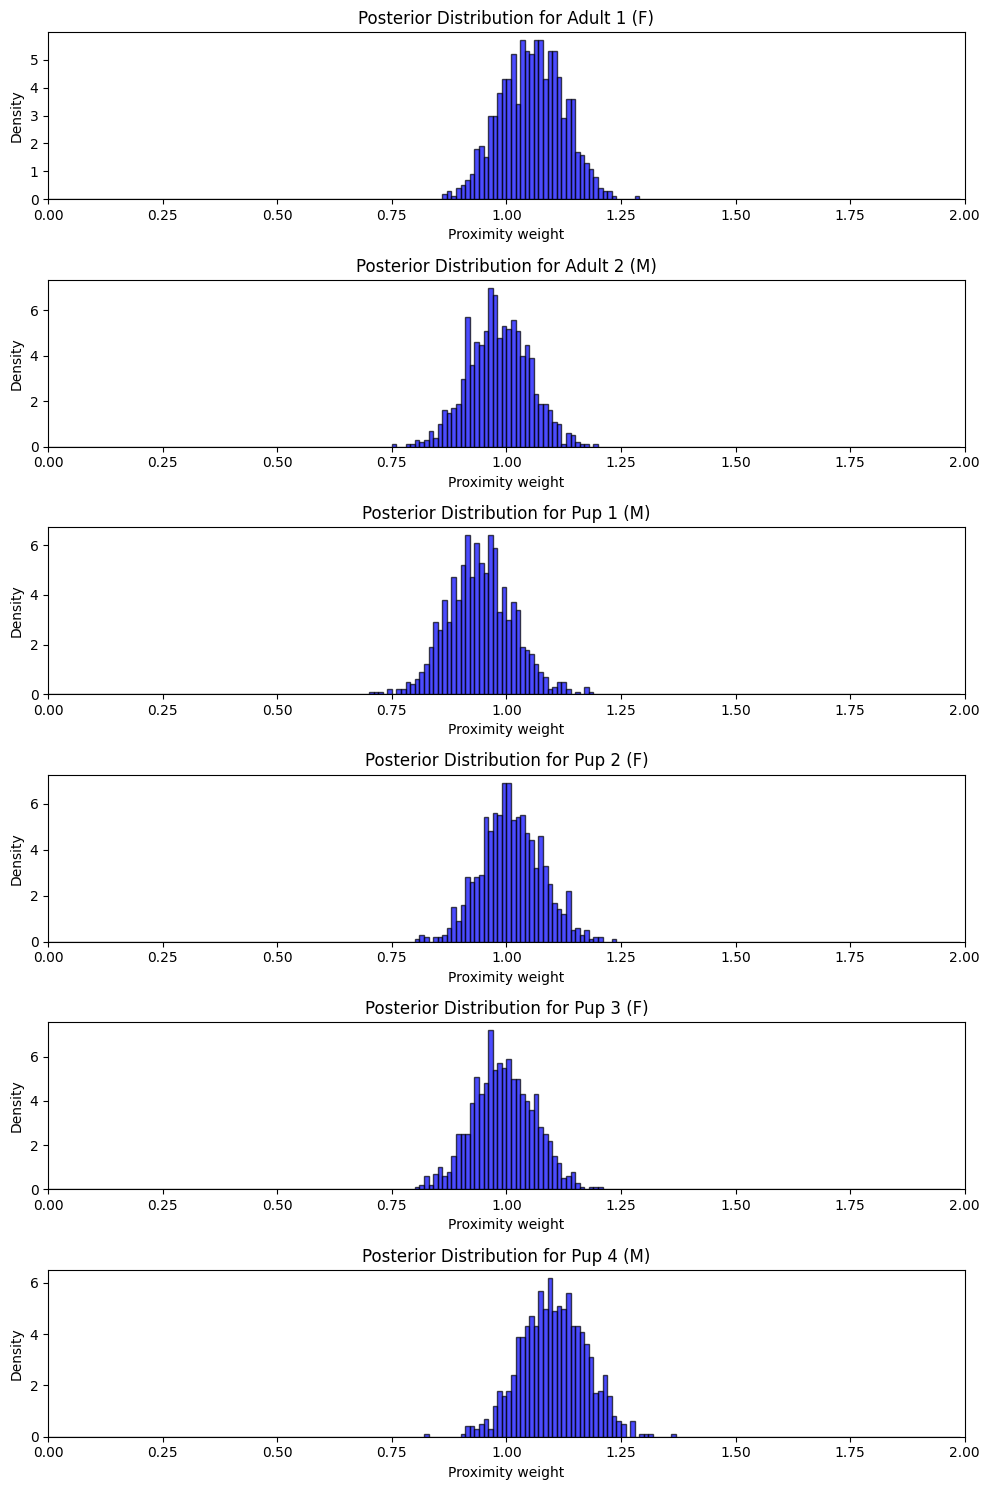

In [59]:


gerbil_names = ["Adult 1 (F)", "Adult 2 (M)", "Pup 1 (M)", "Pup 2 (F)", "Pup 3 (F)", "Pup 4 (M)"]

# Plotting histograms
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
# Define the bin edges with a fixed width of 0.5
bin_edges = np.arange(0, 2, 0.01)

for i in range(6):
    samples_to_plot = samples_no_pooling["weight_proximity_40"][:, 0, i]

    axs[i].hist(
        samples_to_plot, bins=bin_edges, alpha=0.7, color="blue", edgecolor="black", density=True
    )
    axs[i].set_title(f"Posterior Distribution for {gerbil_names[i]}")
    axs[i].set_xlabel("Proximity weight")
    axs[i].set_ylabel("Density")
    axs[i].set_xlim(0,2)


plt.tight_layout()
plt.show()

In [60]:
class GerbilModelPartialPooling(pyro.nn.PyroModule):
    def __init__(
        self,
        predictors: dict,
        leeway=0.4,
    ):
        super().__init__()

        self.predictors = predictors
        self.leeway = leeway
        self.n = len(predictors["forager_id"])

    def forward(
        self,
        data=None,
        proximities=[40, 300],
        leeway=0.4,
    ):
        if data is None:
            data = self.predictors

        visibility = data["visibility"]
        how_far = data["how_far_squared_scaled"]
        forager_ids = data["forager_id"]
        n_foragers = len(forager_ids.unique())

        proximity_names = [f"proximity_{proximity}" for proximity in proximities]
        proximity_tensors = {name: self.predictors[name] for name in proximity_names}

        v = pyro.sample("v", dist.Normal(0.0, leeway))
        b = pyro.sample("b", dist.Normal(0.5, 0.3))

        vs = pyro.sample("vs", dist.Exponential(10.0))
        bs = pyro.sample("bs", dist.Exponential(10.0))

        weights = {}
        global_weights = {}
        sigmas = {}
        global_sigmas = {}
        weighted = {}
        sigmas_weighted = {}

        for key in proximity_names:

            global_weights[key] = pyro.sample(
                f"global_weight_{key}", dist.Normal(0.0, leeway)
            )
            weights[key] = pyro.sample(
                f"weight_{key}",
                dist.Normal(global_weights[key], leeway)
                .expand(torch.tensor([n_foragers]))
                .to_event(1),
            )

            global_sigmas[key] = pyro.sample(
                f"global_sigma_{key}", dist.Exponential(1.0)
            )
            sigmas[key] = pyro.sample(
                f"sigma_{key}",
                dist.Exponential(global_sigmas[key])
                .expand(torch.tensor([n_foragers]))
                .to_event(1),
            )

            weighted[key] = weights[key][..., forager_ids] * proximity_tensors[key]

            sigmas_weighted[key] = (
                torch.abs(proximity_tensors[key]) * sigmas[key][..., forager_ids]
            )

        weighted = list(weighted.values())
        sigmas_weighted = list(sigmas_weighted.values())
        for i in range(1, len(weighted)):
            weighted[i] = weighted[i].view(weighted[0].shape)
            sigmas_weighted[i] = sigmas_weighted[i].view(sigmas_weighted[0].shape)

        mean = pyro.deterministic(
            "mean", torch.stack(weighted).sum(dim=0) + b + visibility * v
        )
        sigma = pyro.deterministic(
            "sigma", torch.stack(sigmas_weighted).sum(dim=0) + bs + visibility * vs
        )

        with pyro.plate("data", self.n, dim=-1):
            pyro.sample("observed_how_far", dist.Normal(mean, sigma), obs=how_far)


gerbil_model_partial_pooling = GerbilModelPartialPooling(predictors)

with pyro.poutine.trace() as tr:
    gerbil_model_partial_pooling(predictors)

In [61]:
guide_partial_pooling = run_svi(gerbil_model_partial_pooling, num_svi_iters=600)
predictive_partial_pooling = Predictive(
    gerbil_model_partial_pooling, guide=guide_partial_pooling, num_samples=1000
)
samples_partial_pooling = predictive_partial_pooling(predictors)

2024-09-28 02:11:42,593 - Starting SVI inference with 600 iterations.
2024-09-28 02:11:42,648 - Step 0, elbo loss: 144972.44664090645
2024-09-28 02:11:52,551 - Step 200, elbo loss: 26116.97475112297
2024-09-28 02:12:02,477 - Step 400, elbo loss: 8573.784615274271
2024-09-28 02:12:12,283 - SVI inference completed in 29.69 seconds.


In [62]:
summary(samples_partial_pooling)
samples_partial_pooling = predictive_partial_pooling(predictors_for_eval)
mean_preds = samples_partial_pooling["observed_how_far"].mean(axis=0)
observed_mean = torch.mean(predictors["how_far_squared_scaled"])
tss = torch.sum((predictors["how_far_squared_scaled"] - observed_mean) ** 2)
rss = torch.sum((predictors["how_far_squared_scaled"] - mean_preds) ** 2)

r_squared = 1 - (rss / tss)
print(r_squared)

v: tensor([-0.0674]) +/- tensor([0.0407])
weight_proximity_40: tensor([[1.0743, 0.9986, 1.0098, 1.0283, 1.0153, 1.1202]]) +/- tensor([[0.0576, 0.0658, 0.0540, 0.0601, 0.0531, 0.0565]])
weight_proximity_300: tensor([[0.5586, 0.5891, 0.6314, 0.6058, 0.5556, 0.5937]]) +/- tensor([[0.0442, 0.0426, 0.0447, 0.0376, 0.0421, 0.0418]])
tensor(0.4996, dtype=torch.float64)


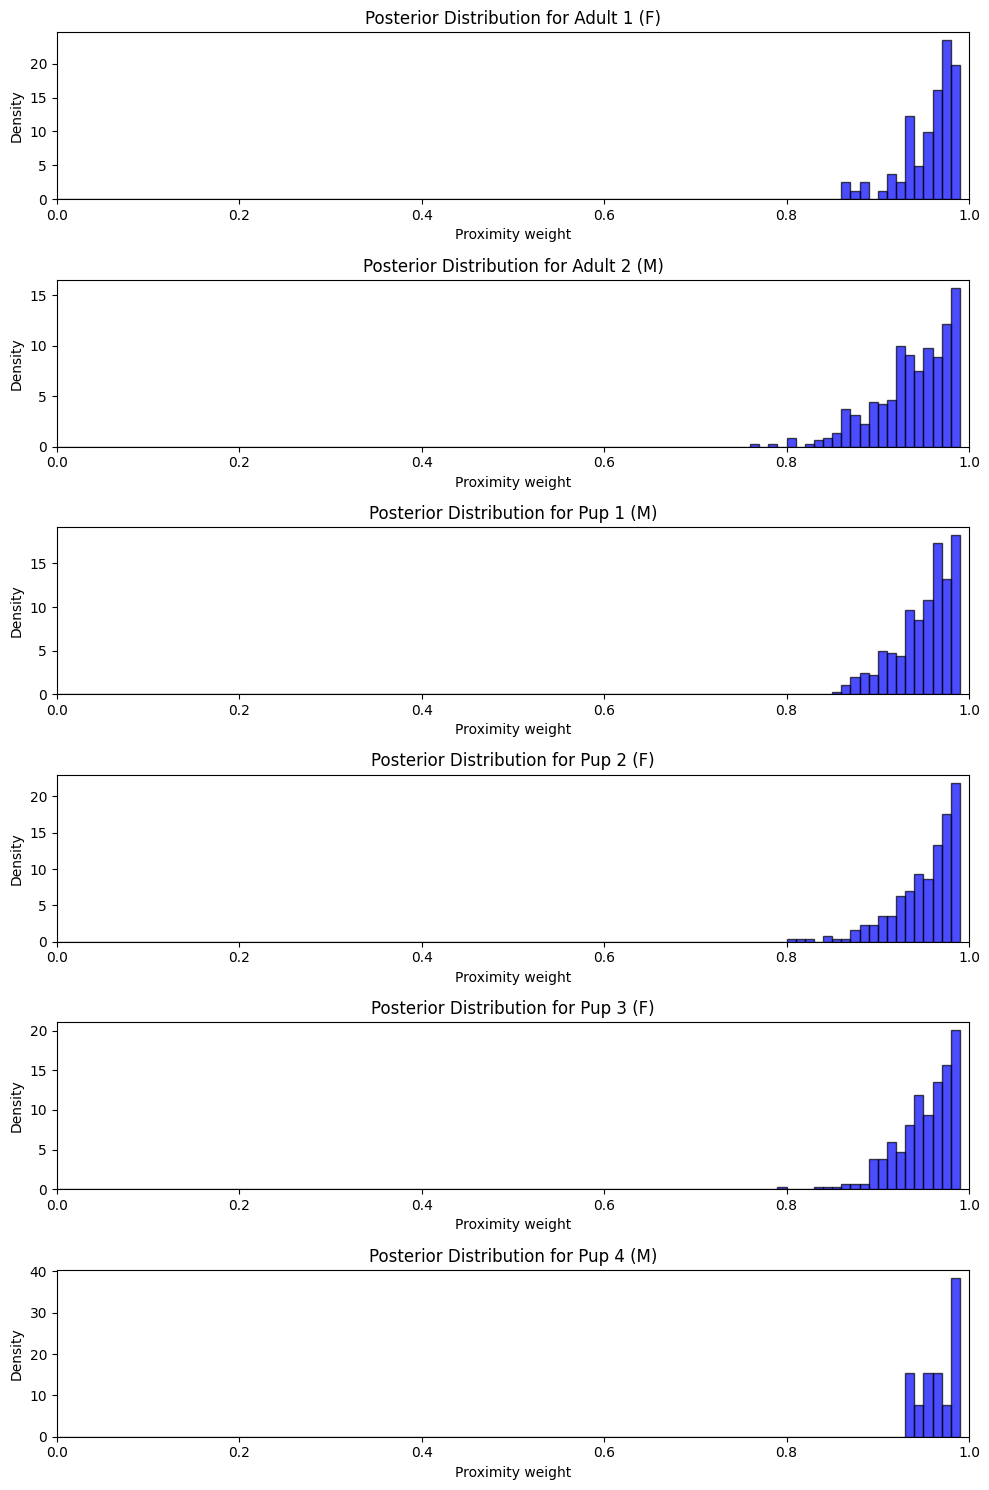

In [63]:
gerbil_names = ["Adult 1 (F)", "Adult 2 (M)", "Pup 1 (M)", "Pup 2 (F)", "Pup 3 (F)", "Pup 4 (M)"]

# Plotting histograms
fig, axs = plt.subplots(6, 1, figsize=(10, 15))
# Define the bin edges with a fixed width of 0.5
bin_edges = np.arange(0, 1, 0.01)

for i in range(6):
    samples_to_plot = samples_partial_pooling["weight_proximity_40"][:, 0, i]

    axs[i].hist(
        samples_to_plot, bins=bin_edges, alpha=0.7, color="blue", edgecolor="black", density=True
    )
    axs[i].set_title(f"Posterior Distribution for {gerbil_names[i]}")
    axs[i].set_xlabel("Proximity weight")
    axs[i].set_ylabel("Density")
    axs[i].set_xlim(0, 1)


plt.tight_layout()
plt.show()